![Liar](imgs/Liar.png)
*Author: DALL-E*

# Fake News Detection using Machine Learning

"Data is the new oil". Since [the famous The Economist's story](https://www.economist.com/leaders/2017/05/06/the-worlds-most-valuable-resource-is-no-longer-oil-but-data?utm_medium=cpc.adword.pd&utm_source=google&ppccampaignID=19495686130&ppcadID=&utm_campaign=a.22brand_pmax&utm_content=conversion.direct-response.anonymous&gad_source=1&gclid=CjwKCAiA3JCvBhA8EiwA4kujZmxF0ynGlI76OAlLTLqtBIl2XnsI117OrERhCGo-X6cqYPFX_DIaRhoCnxgQAvD_BwE&gclsrc=aw.ds), this phrase became a common refrain. Setting aside all discussion and criticism about this metaphor, the importance of the data as a resource in the digital era is a general agreement. The aknownledgement of this statement also implies the aknownledgment of both sides of this coin. Data can be as benefical as dangerous, and in the wrong hands, [data and its attendant distortion can become a weapon](https://www.linkedin.com/pulse/while-data-may-worth-trillions-new-oil-dante-a-disparte/).

In this project we'll develop a Machine Learning model to identify fake news. We'll use the Kaggle's [REAL and FAKE news dataset](https://www.kaggle.com/datasets/nopdev/real-and-fake-news-dataset), that contains a small collection of real news articles labeled as REAL or FAKE. This project's goal is to give a basic understanding of how to process real text data and use it to solve important actual problems.

# Imports
This project will use some of the most well known libraries for Scientific Computing, Data Visualization, Natural Language Processing and Machine Learning available for Python:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Seaborn](https://seaborn.pydata.org/)
- [Scikit-Learn](https://scikit-learn.org/stable/)
- [NLTK](https://www.nltk.org/index.html)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- [LightGBM](https://lightgbm.readthedocs.io/en/stable/)

In [1]:
import os
import re
import time

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from wordcloud import WordCloud

# Dataset Overview

## Data Loading

As we'll use data from Kaggle, it's convenient to use [Kaggles own client tool](https://github.com/Kaggle/kaggle-api) to download the dataset.

In [2]:
if not os.path.isfile("data/news.csv"):
    !kaggle datasets download -d nopdev/real-and-fake-news-dataset
    !unzip real-and-fake-news-dataset.zip -d data
    !rm real-and-fake-news-dataset.zip

With this, it's just a matter of loading the data using Pandas.

In [3]:
df = (
    pd.read_csv("data/news.csv")
    .sample(frac=1)
    .reset_index(drop=True)
    .drop("Unnamed: 0", axis="columns")
)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6335, 3)


,title,text,label
0,Here is Elon Musk’s True Mars On Earth Plan,Here is Elon Musk’s True Mars On Earth Plan 11...,FAKE
1,"Saudi Arabia, Egypt to Invade Yemen",Egypt and Saudi Arabia are planning a ground o...,REAL
2,"“We won, you lost, get over it” Brexiters told...","Thursday 3 November 2016 “We won, you lost, ge...",FAKE
3,US Moving ISIS Fighters From Iraq To Syria To ...,"— Jim Jatras (@JimJatras) October 29, 2016 \nJ...",FAKE
4,Hillary Helped Chelsea’s Friend With VISA Issu...,Trey Gowdy Literally Walks Out After Dropping ...,FAKE


The data is loaded using the `read_csv` function. We also shuffle the data by calling `.sample(frac=1)` and `.reset_index(drop=True)`, to give some randomness to the data. We also drop the useless `Unnamed: 0` column.

The data itself has 6335 entries and 3 feature columns:
- **title**: The news's title.
- **text**: The text body of the news.
- **label**: A binary feature, indicating if the corresponding news is **REAL** or **FAKE**.

All text is in english. Unfortunatelly, the dataset doesn't explicitly supply the dates, but it seems that the majority of the news are about the context of US presidential elections.

# Text Data Processing Basics

Natural Language Processing (NLP) combines multiple technologies to enable machine "understanding" of human language, in both object and subjective levels.

I choose NLTK as our main NLP framework. Quoting the framework documention's site:
> NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

The following section provider a basic understanding of the NLP concepts that we'll be using in this project.

## Corpus
Refers to the body of the text, and can be in multiple languages. For a collection of texts, we call it a *corpora*.

## Tokenization
It's the process of breaking down the text in individual tokens. Depending of the use, there are multiple types of tokens, like:
- **Word Tokenization:** text is broken into words.
- **Sentence Tokenization:** text is broken into individual sentences.
- **Subword Tokenization:** text words are broken down into smaller units or subwords.
- **Character Tokenization:** text is broken into individual characters.

![Tokenization types](imgs/Tokenizations.png)
*Author: [Aysel Aydin](https://ayselaydin.medium.com/3-tokenization-in-nlp-the-art-of-breaking-down-text-data-5e1ba6786901)*

Punctuations and special characters are also removed.

## Normalization
Is the process of transforming text into a single canonical form, reducing its randomness and bringing it closer to a predefined "standard"

### Stemming
Is the process of reducing the words to their root form. For example:

![Stemming Example](imgs/Stemming.png)

Note that words have been reduced to something that isn't an actual word. This is because stemming is a heuristic process that achieves normalization by just striping the ends of words. It's fast and, generally, effective. But it can introduce errors, like reducing words higher (*over-stemming*) or lower (*under-stemming*) than the necessary.

### Lemmatization
Reduces words to their base word, reducing the inflected words properly and that the root word is a actual word. For example:

![Lemmatization Example](imgs/Lemmatization.png)

It's gennerallya more sophisticated process than stemming, and it can be further improved if word contexts are provided, which can be achieved through a process called [parts-of-speech (POS) tagging](https://www.nltk.org/book/ch05.html).

## Lexicons
According to the Cambridge Dictionary, lexicon is a list of all the words used in a particular language or subject (a.k.a dictionary). In the context of NLP, lexicon is a group of words associated to specific features in a certain style (e.g..: sparts of speech segmentation, sentiment). It is used as source for interpreting human language by providing special information meanings and grammatical properties of those words.

## Stop Words
These are commonly used words in a language that, without context (i.e.: by themselves), carry very litter useful information, like punctuation, articles, pronoums, etc. Denpending of the use case, they can be useless and totally removed from analysis or so important that their presence is required. This project shows both examples.

## Bag of words
*Bag of Words* (*BoW*) is one of the most well known text *feature extraction* technique. It's output is a table with counts of words occorences in a set of documents.

![Bag Of Words Example](imgs/BagOfWords.png)
*Author: [Aysel Aydin](https://ayselaydin.medium.com/4-bag-of-words-model-in-nlp-434cb38cdd1b)*

## TF-IDF
*Term Frequency - Inverse Document Frequency* (*TF-IDF*) is a text *feature extraction* technique, similar to *BoW* but, instead of word occurences, results in a table with *words importances*. *Word importance* is a measure of a word frequency in specific documento w.r.t the word's *inverse frequency* in all documents. This can be mathematically defined as follows:

$$
W_{x, y} = tf_{x, y} \times \log\frac{N}{df_x}
$$
where:
- $x$ is a specific word;
- $y$ is a specific document;
- $tf_{x, y}$ is the frequency of $x$ in $y$;
- $df_x$ is the number of documents containing $x$;
- $N$ is the total number of documents.

Basically, a word is important for a text document if it occurs a lot in that specific document but rarely in all others.

# Additional Data Loading
Now, before continuing with the analysis, we'll download and load the data that contains the definitions of the *punctuation*, *stop words* and the [VADER lexicon](https://github.com/cjhutto/vaderSentiment) that we'll use. Thanks to the NLTK package, this process is very straight forward.

In [4]:
nltk.download("punkt", download_dir="data") # punctuation
nltk.download("stopwords", download_dir="data") # stop words
nltk.download("vader_lexicon", download_dir="data") # VADER lexicon

# NLTK seem to not unzip the Vader lexicon automatically =[
if not os.path.isfile("data/sentiment/vader_lexicon/vader_lexicon.txt"):
    !unzip data/sentiment/vader_lexicon.zip -d data/sentiment

nltk.data.path.append("data")

[nltk_data] Downloading package punkt to data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Exploratory Data Analysis
Our analysis will be driven by the following base questions:
- How balanced is the data wih relation to the news type (fake and real)?
- How fake news data differs from real news data?
    - News text size
    - Most common words
    - Overall sentiment

## How balanced is the data with relation to the news type?
First of all, let's check the volumetry proportion fake/real news. A count plot of the type occurrencies can answer that.

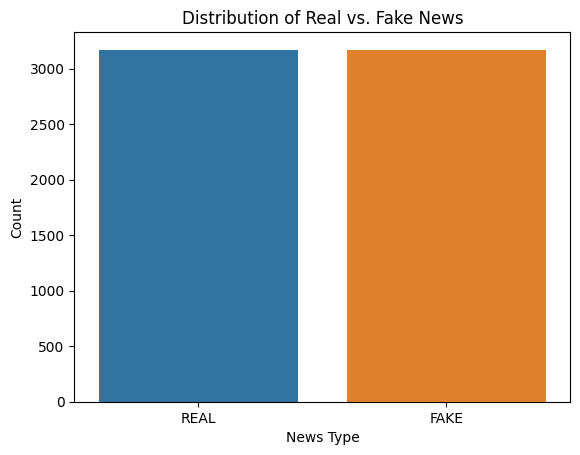

In [5]:
sns.countplot(x="label", order=["REAL", "FAKE"], data=df, hue="label", hue_order=["REAL", "FAKE"])
plt.title("Distribution of Real vs. Fake News")
plt.xlabel("News Type")
plt.ylabel("Count")
plt.show()

Real and fake news have almost the same proportions. Good. We don't have to worry about data unbalancing when we reach the Machine Learning model development.

New let's check the characteristics of the news data.

## How fake news data differs from real news data?
The news data itself only has 2 features: the title and the text body of each news. For the analysis of text size and word occurence the presence of stop words can introduce too much noise in the measurements, so we'll strip them off. Also, we'll use the [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/) to stem the words and give them some standard form.

In [6]:
stop_words = set(stopwords.words("english"))  # we're explicitly loading the stop words for English language.

porter = PorterStemmer()


def preprocess_text(text):
    # We'll apply regex substitution to keep alphabetical token only, removing any other kind.
    text = re.sub("[^a-zA-Z]", " ", text).lower()
    # The default NLTK word tokenizer breaks sentences down by whitespaces and punctuation.
    word_tokens = word_tokenize(text)
    filtered_sequence = [
        porter.stem(word) for word in word_tokens if not word.lower() in stop_words
    ]
    # Join remaining tokens toghether again.
    return " ".join(filtered_sequence)

# We'll apply our analysis to both title and text body of the news.
df["title_clean"] = df["title"].apply(preprocess_text)
df["text_clean"] = df["text"].apply(preprocess_text)
df.head()

,title,text,label,title_clean,text_clean
0,Here is Elon Musk’s True Mars On Earth Plan,Here is Elon Musk’s True Mars On Earth Plan 11...,FAKE,elon musk true mar earth plan,elon musk true mar earth plan game n guid elon...
1,"Saudi Arabia, Egypt to Invade Yemen",Egypt and Saudi Arabia are planning a ground o...,REAL,saudi arabia egypt invad yemen,egypt saudi arabia plan ground oper yemen egyp...
2,"“We won, you lost, get over it” Brexiters told...","Thursday 3 November 2016 “We won, you lost, ge...",FAKE,lost get brexit told outsid high court,thursday novemb lost get brexit told outsid hi...
3,US Moving ISIS Fighters From Iraq To Syria To ...,"— Jim Jatras (@JimJatras) October 29, 2016 \nJ...",FAKE,us move isi fighter iraq syria toppl assad,jim jatra jimjatra octob jatra said us spent m...
4,Hillary Helped Chelsea’s Friend With VISA Issu...,Trey Gowdy Literally Walks Out After Dropping ...,FAKE,hillari help chelsea friend visa issu within hour,trey gowdi liter walk drop hillari comey repor...


As we can see, we store the cleaned titles and text bodies in additional feature columns, so we don't loose the original ones. We'll need them to apply the sentiment analysis a bit later.

### Text Sizes
The sizes analysis consists in just checking the distributions of the pure text lenghts of each news type.

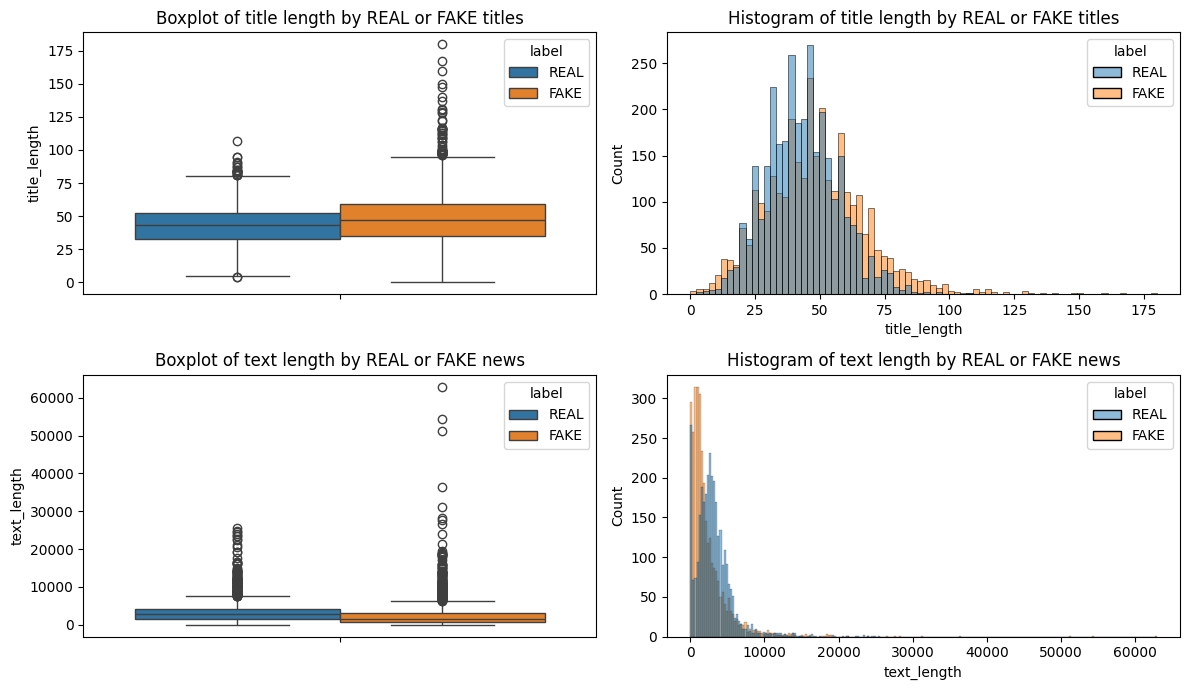

In [7]:
df["title_length"] = df["title_clean"].str.len()
df["text_length"] = df["text_clean"].str.len()

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
sns.boxplot(y="title_length", data=df, hue="label", hue_order=["REAL", "FAKE"])
plt.title("Boxplot of title length by REAL or FAKE titles")

plt.subplot(2, 2, 3)
sns.boxplot(y="text_length", data=df, hue="label", hue_order=["REAL", "FAKE"])
plt.title("Boxplot of text length by REAL or FAKE news")

plt.subplot(2, 2, 2)
sns.histplot(x="title_length", data=df, hue="label", hue_order=["REAL", "FAKE"])
plt.title("Histogram of title length by REAL or FAKE titles")

plt.subplot(2, 2, 4)
sns.histplot(x="text_length", data=df, hue="label", hue_order=["REAL", "FAKE"])
plt.title("Histogram of text length by REAL or FAKE news")

plt.tight_layout()
plt.show()

- The presence of **outliers** in the bloxplots indicates that the dataset contains articles with unusually long titles and text lengths for both real and fake news.
- The boxplot shows that **real news titles tend to be shorter than fake news titles**. The histogram of title lenghts further supports this conclusion by showing that the distribution of real news peaks at a lower character count and decreases more sharply than the distribution of fake news titles.
- In constrast, **real news articles tend to have a wider range of text lengths**, although the median text length of both news types a pretty similar. Again, the histogram supports the boxplot theory by showing that **fake news articles have a lower word count**, clustering towards the left side of the plot, in contrast to the **longer right tail** displayed by the real news articles distribution

### Most common words
Let's plot the word clouds for titles and text for both types of news.

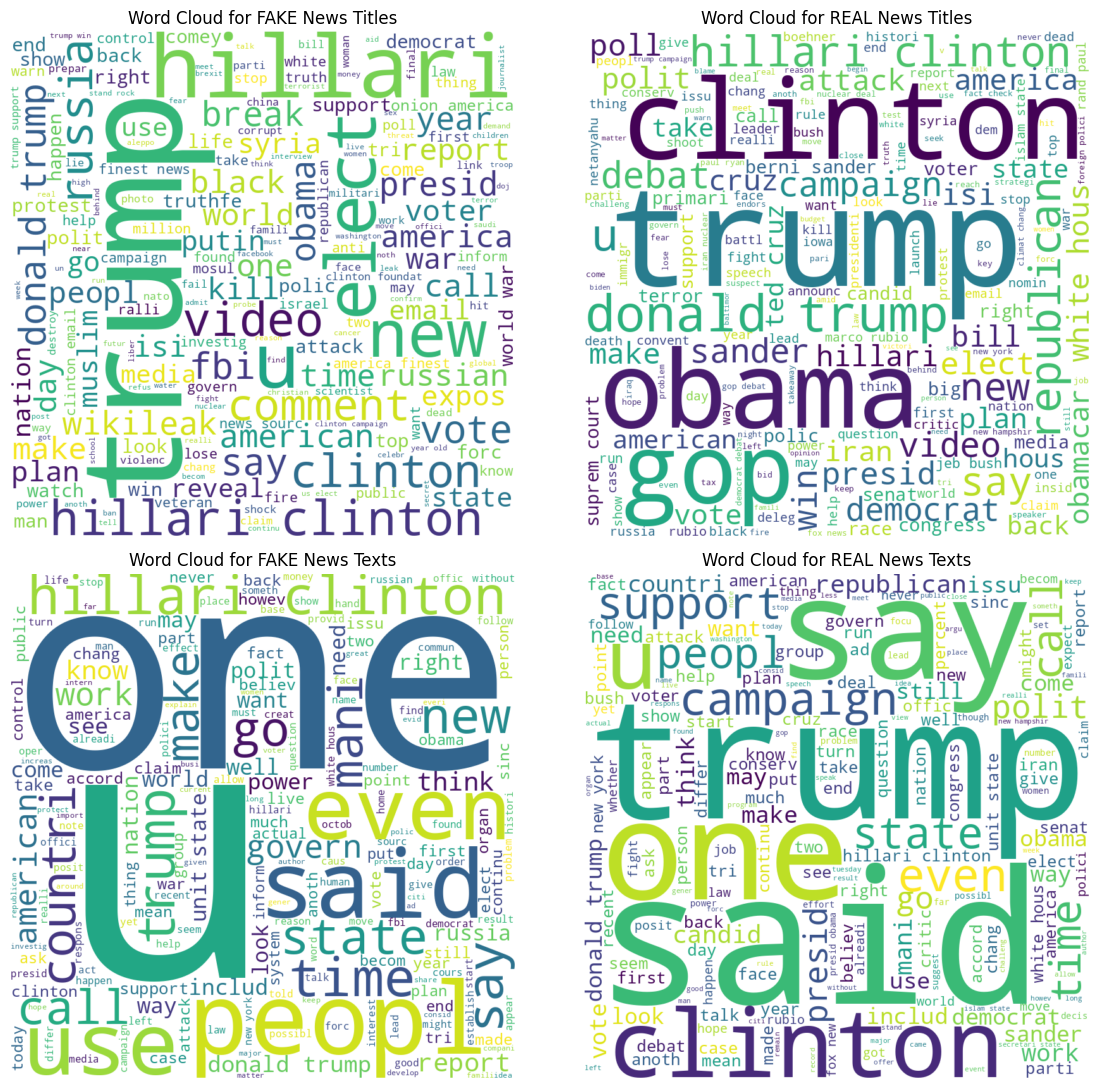

In [8]:
plt.figure(figsize=(12, 11))

for idx, news_type in enumerate(("FAKE", "REAL")):
    titles = " ".join(df[df["label"] == news_type]["title_clean"])
    news_wordcloud = WordCloud(
        width=800, height=800, background_color="white"
    ).generate(titles)
    plt.subplot(2, 2, idx + 1)
    plt.imshow(news_wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {news_type} News Titles")
    plt.axis("off")

for idx, news_type in enumerate(("FAKE", "REAL")):
    texts = " ".join(df[df["label"] == news_type]["text_clean"])
    news_wordcloud = WordCloud(
        width=800, height=800, background_color="white"
    ).generate(texts)
    plt.subplot(2, 2, idx + 3)
    plt.imshow(news_wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {news_type} News Texts")
    plt.axis("off")

plt.tight_layout()
plt.show()

- Certain names and terms suc as "Trump", "Clinton" and "Hillari" are proeminently features in both fake and real news, suggesting that **political figures are common subjects in news articles regardless of their veracity**.
- Fake titles and text seem to feature sensational or emotially charged words (e.g.: lie, attack, war, power), as well as controversial topics (e.g.: video, email, report), indicating the use a **tendency to use more provocative language that presents speculation or opinion as fact**.
- The real news, in contrast, and while still featuring some of the same political names, **contains a notable presence of more diverse and policy-oriented terms** (e.g.: government, house, president, country, debate), which might reflect a broader coverage of topics and a focus on governance and national issues.

In addition to the above mentioned, the choice of words can also reflect the sentiment and tone of the articles, as we'll see next.

### Overall sentiment
For the sentiment analysis we'll want the raw (unfiltered) text. Not only the choice of words, but punctuation and even letter case might indicate the tone and sentiment of the expression.

For the sentiment classification itself, we'll use NLTK's [SentimentIntensityAnalyzer](https://www.nltk.org/api/nltk.sentiment.SentimentIntensityAnalyzer.html?highlight=sentimentintensity), which in turn uses the VADER lexicon to give a floating point score representing sentiment polarity for a specific text. A score closer to -1.0 represents a strogn negative sentiment, while a score closer to 1.0 represents a strong positive sentiment.

For our analysis, a float score won't be important though. So, based on this score, we'll classify the sentiment polarity in *Strongly Negative*, *Negative*, *Neutral*, *Positive* and *Strongly Positive*, in this crescent order.

In [9]:
sia = SentimentIntensityAnalyzer(
    lexicon_file="data/sentiment/vader_lexicon/vader_lexicon.txt"
)


def get_sentiment_score(text):
    polarity_score = sia.polarity_scores(text)["compound"]
    if polarity_score <= -0.6:
        return "Strongly Negative"
    elif polarity_score <= -0.2:
        return "Negative"
    elif polarity_score <= 0.2:
        return "Neutral"
    elif polarity_score <= 0.6:
        return "Positive"
    else:
        return "Strongly Positive"


df["title_sentiment"] = df["title"].apply(get_sentiment_score)
df["text_sentiment"] = df["text"].apply(get_sentiment_score)

df.head()

,title,text,label,title_clean,text_clean,title_length,text_length,title_sentiment,text_sentiment
0,Here is Elon Musk’s True Mars On Earth Plan,Here is Elon Musk’s True Mars On Earth Plan 11...,FAKE,elon musk true mar earth plan,elon musk true mar earth plan game n guid elon...,29,1404,Positive,Strongly Positive
1,"Saudi Arabia, Egypt to Invade Yemen",Egypt and Saudi Arabia are planning a ground o...,REAL,saudi arabia egypt invad yemen,egypt saudi arabia plan ground oper yemen egyp...,30,594,Neutral,Strongly Positive
2,"“We won, you lost, get over it” Brexiters told...","Thursday 3 November 2016 “We won, you lost, ge...",FAKE,lost get brexit told outsid high court,thursday novemb lost get brexit told outsid hi...,38,715,Positive,Strongly Positive
3,US Moving ISIS Fighters From Iraq To Syria To ...,"— Jim Jatras (@JimJatras) October 29, 2016 \nJ...",FAKE,us move isi fighter iraq syria toppl assad,jim jatra jimjatra octob jatra said us spent m...,42,917,Neutral,Strongly Negative
4,Hillary Helped Chelsea’s Friend With VISA Issu...,Trey Gowdy Literally Walks Out After Dropping ...,FAKE,hillari help chelsea friend visa issu within hour,trey gowdi liter walk drop hillari comey repor...,49,765,Positive,Strongly Negative


With this, we can count the occurrencies of each sentiment polarity class in articles titles and text.

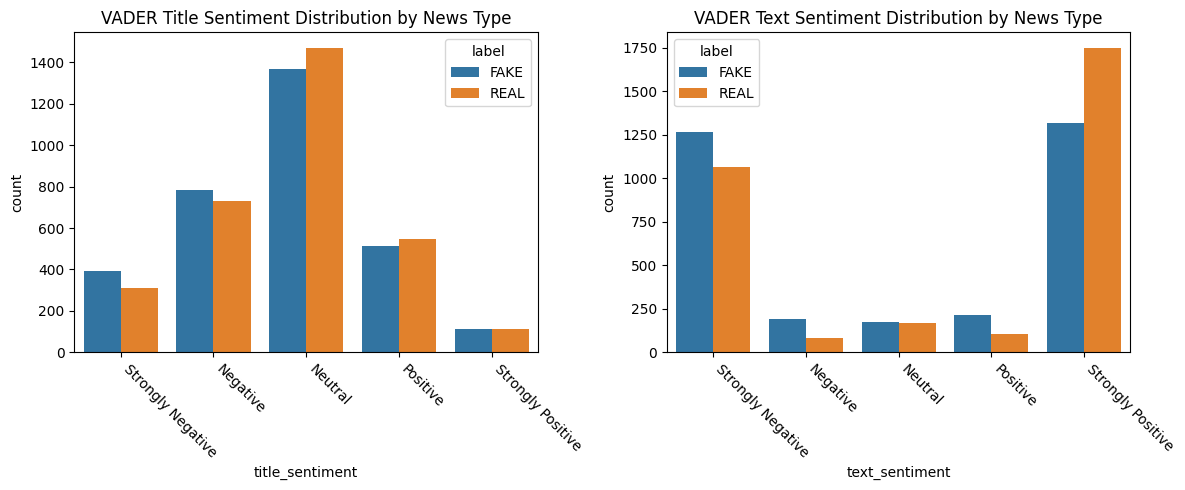

In [10]:
order = ["Strongly Negative", "Negative", "Neutral", "Positive", "Strongly Positive"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x="title_sentiment", order=order, data=df, hue="label")
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=-45, ha="left")
plt.title("VADER Title Sentiment Distribution by News Type")
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x="text_sentiment", order=order, data=df, hue="label")
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=-45, ha="left")
plt.title("VADER Text Sentiment Distribution by News Type")

plt.tight_layout()
plt.show();

- Real news titles have a higher count of *Neutral* sentiment compared to fake news titles, seggesting that real news tends to use a more measured and objective tone in titles.
- Fake news titles show a broader distribution across different sentiments, with notably higher counts in *Negative* and *Strongly Negative* sentiments, indicating a tendency towards more emotionally charged language.
- Real news text bodies shows a significant lean towards *Neutral*, reinforcing the idea that the language used is more factual.
- Fake news has a much higher presence in *Strongly Negative* setiment than real news, which aligns with the idea that fake news may use language that is meant to incite strong emotional reactions, urgency or controversy.
- Both real and fake news have smaller counts for *Positive* and *Strongly Positive* sentiments in their titles and text bodies, suggesting that **positive sentiment is less commonly used in news regardless of its veracity**.

# Machine Learning Model
For the Machine Learning model, we'll go for a simple approach. We'll basically extract the TF-IDF vectors from the news articles texts and use them as features. Throughout my tests, I tried to use other features like TF-IDF vectores from the titles and sentiment polarity from both texts and titles, but I didn't get any substantial improvement on the model's accuracy.

We'll choose the model itself from a list of pre-defined models and parameters. For each one we'll run a cross validation of 5 folds using the train set. The model's evaluation will be based on the cross-validation average accuracy, accuracy on test set, inferecence time and model size.

## Train and Test Sets.
20% of the data will separated as the test set while the remaining data will be the train set. The data will be stratified: the proportions of REAL and FAKE news will be mantained in both data sets.

In [11]:
# We'll use the already cleaned "text" colum.
X = df["text_clean"]
y = df["label"]

# We'll binarize the target feature right, way before the spliting, as this process is neither dependant or dependency for the models' training.
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)

# The parameter "stratify" tells wich feature to be used for reference to mantain the data proportions ("label" in our case).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5068,) (5068,) (1267,) (1267,)


## TF-IDF Transformation
We'll use the Scikit-Learn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to extract the TF-IDF vectors.

In [12]:
data_transformer = TfidfVectorizer(stop_words="english")

## Models Selection
We'll evaluate the following list of models.
- Logistic Regression
- Support Vector Machines
- Random Forest Classifier
- Multinomial Naive Bayes
- XGBoost Classifier
- LightGBM Classifier

Most the the parameters configurations used are default.

In [13]:
models = {
    # max_iter is set to avoid early termination of the algorithm.
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # The linear kernel will avoid overfitting.
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB(),
    # use_label_encoder was deprecated, so we set it to False to avoid warnings.
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}

In [14]:
results_entries = []

models_dir = os.path.join("data", "models")
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

for name, model in models.items():
    print(f"Evaluating model {name}")
    pipeline = make_pipeline(data_transformer, model)

    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")

    start_train_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    start_inference_time = time.time()
    y_pred = pipeline.predict(X_test)
    inference_time = time.time() - start_inference_time

    test_accuracy = accuracy_score(y_test, y_pred)

    model_file = f'{name.replace(" ", "_").lower()}_model.joblib'
    joblib
    model_path = os.path.join(models_dir, model_file)
    joblib.dump(pipeline, model_path)
    model_size = os.path.getsize(model_path)

    results_entries.append(
        {
            "Model": name,
            "Avg Accuracy": scores.mean(),
            "Avg Std": scores.std(),
            "Test Accuracy": test_accuracy,
            "Train Time": train_time,
            "Inference Time": inference_time,
            "Model Size KB": model_size / 1024,
        }
    )

results = pd.DataFrame(results_entries)

Evaluating model Logistic Regression
Evaluating model SVM
Evaluating model Random Forest
Evaluating model MultinomialNB
Evaluating model XGBoost
Evaluating model LightGBM
[LightGBM] [Info] Number of positive: 2029, number of negative: 2025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262730
[LightGBM] [Info] Number of data points in the train set: 4054, number of used features: 5521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500493 -> initscore=0.001973
[LightGBM] [Info] Start training from score 0.001973
[LightGBM] [Info] Number of positive: 2029, number of negative: 2025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265034
[LightGBM] [Info] Number of data points in the train set: 4054, numbe

In [15]:
results.sort_values(["Avg Accuracy", "Test Accuracy"], ascending=False)

,Model,Avg Accuracy,Avg Std,Test Accuracy,Train Time,Inference Time,Model Size KB
1,SVM,0.924626,0.005960,0.934491,79.544979,3.757677,6995.809570
5,LightGBM,0.921667,0.005215,0.922652,6.749631,0.318756,2261.651367
4,XGBoost,0.916539,0.010273,0.921073,14.633252,0.336188,1303.505859
0,Logistic Regression,0.908842,0.009596,0.914759,1.376841,0.348594,1412.641602
2,Random Forest,0.892071,0.008756,0.901342,5.513466,0.373576,13965.408203
3,MultinomialNB,0.830310,0.010880,0.840568,1.258667,0.301495,2335.857422


- SVM is likely the best performer in therms of dcross-validation average accuracy and test accuracy, but his result comes at the cost of significantly longer training and inferences times and larger model size compared to other models.
- LightGBM and XGBoost offer a good compromiise between hogh accuracy and efficiency in termos of both training/inference time and model size.
- In the contest between LightGBM and XGBoost, the first has a sightly better performance and efficiency, with the addition of a more stable performance indicated by the lower standard deviation.

With the points above and having in mind the trade-off between accuracy and efficiency, we'll follow with the **LGBMClassifier** for the rest of our analysis.

## Analysis of the Final Model
Now that we have our chosen model, it's time to train it using the train set and analyze the overall performance on the test set.

In [16]:
model = make_pipeline(data_transformer, lgb.LGBMClassifier(random_state=42))
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2537, number of negative: 2531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319747
[LightGBM] [Info] Number of data points in the train set: 5068, number of used features: 6247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500592 -> initscore=0.002368
[LightGBM] [Info] Start training from score 0.002368


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

We'll create a dataframe, containing the real and predicted labels for each news. We'll also need the clean article texts.

In [17]:
inferece_df = pd.DataFrame(
    data={
        "news_text": X_test,
        "label": y_encoder.inverse_transform(y_test),
        "prediction": y_encoder.inverse_transform(model.predict(X_test)),
    }
)
inferece_df

,news_text,label,prediction
1601,congress face june deadlin law expir paul spee...,REAL,REAL
2037,heather callaghan editor peopl catch obes equa...,FAKE,FAKE
2572,washington cnn central theme carli fiorina nas...,REAL,REAL
2710,review michael moor new york citi union squar ...,FAKE,FAKE
4618,least nine peopl arrest wednesday st loui poli...,REAL,REAL
...,...,...,...
2975,tapper host network state union sunday show le...,REAL,REAL
5627,russian aircraft carri passeng seven crew memb...,REAL,REAL
1764,bill reilli respond mother jone stori accus ma...,REAL,REAL
4430,link origin post theantediluvian look like eve...,FAKE,FAKE


With all set, our analysis will be driven by the following questions:
- How much and how does our model's predictions fails?
- Does the text sizes characteristics of the articles are maintained w.r.t their coresponding news types?
- Does the common words of the articles are maintained w.r.t their coresponding news types?
- Does the text sentiment characteristics of the articles are maintained w.r.t their coresponding news types?

### How much and how does our model's predictions fails?
Let's plot the model's [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

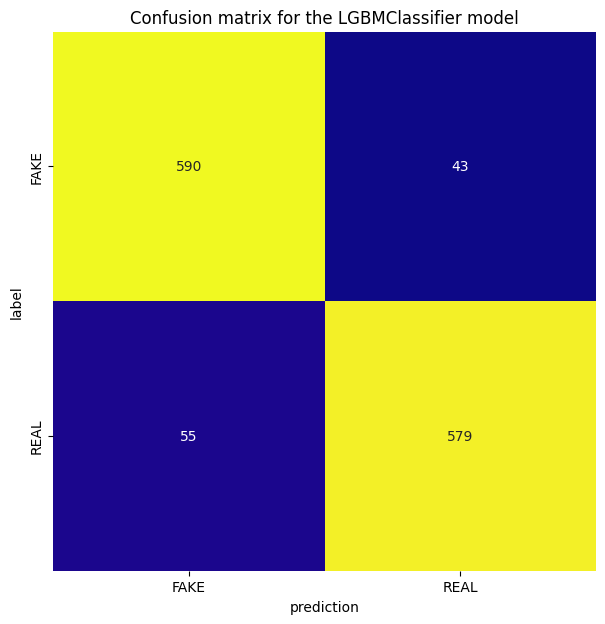

In [18]:
conf_matrix = confusion_matrix(inferece_df["label"], inferece_df["prediction"])
plt.figure(figsize=(7, 7))
ax = sns.heatmap(conf_matrix, annot=True, cbar=False, cmap="plasma", fmt="g")
ax.set_xlabel("prediction")
ax.set_xticklabels(["FAKE", "REAL"])
ax.set_ylabel("label")
ax.set_yticklabels(["FAKE", "REAL"])
plt.title(f"Confusion matrix for the {model.steps[-1][-1].__class__.__name__} model");

Let's also check its precision, recall and F1 score of the model.

In [19]:
print(classification_report(inferece_df["label"], inferece_df["prediction"]))

              precision    recall  f1-score   support

        FAKE       0.91      0.93      0.92       633
        REAL       0.93      0.91      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



- These metrics indicate that the model is performing well in detecting real news, with a string balance between precision and recall.
- The high precision suggests that there are relatively few false alarms, and the high recall means that the model is good at catching most of the real news.
- The F1  score, being close to the precision and recall values, shows that the model doesn't sign iificantly favor one measure over the other, which is often desirable in a balanced classification task.

Now, we'll check general characteristics of the errors. So we'll separate them in a new dataframe.

In [20]:
errors = inferece_df[inferece_df["label"] != inferece_df["prediction"]].copy()

We'll also retrieve the sentiment polarity of each article.

In [21]:
errors["text_clean"] = errors["news_text"].apply(preprocess_text)
errors["text_sentiment"] = errors["news_text"].apply(get_sentiment_score)
errors.head()

,news_text,label,prediction,text_clean,text_sentiment
5168,suprem court unanim decid defend found guilti ...,REAL,FAKE,suprem court unanim decid defend found guilti ...,Negative
1804,know least percent american heard live still o...,REAL,FAKE,know least percent american heard live still o...,Strongly Positive
2826,u continu support israel,REAL,FAKE,u continu support israel,Positive
3868,suspect captur ambush style kill two iowa cop ...,FAKE,REAL,suspect captur ambush style kill two iowa cop ...,Strongly Negative
2635,infect hospit nearli alway prevent one estim d...,REAL,FAKE,infect hospit nearli alway prevent one estim d...,Strongly Negative


### Does the text sizes characteristics of the articles are maintained w.r.t their coresponding news types?
Let's plot the the boxplot and histogram of the text size distribution of the prediction errors.

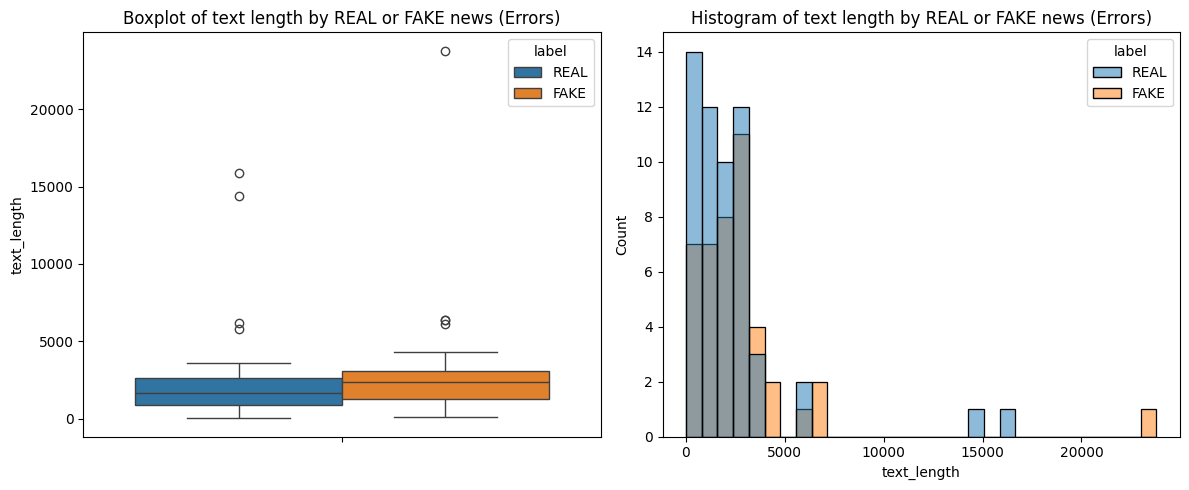

In [22]:
errors["text_length"] = errors["text_clean"].str.len()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="text_length", data=errors, hue="label", hue_order=["REAL", "FAKE"])
plt.title("Boxplot of text length by REAL or FAKE news (Errors)")

plt.subplot(1, 2, 2)
sns.histplot(x="text_length", data=errors, hue="label", hue_order=["REAL", "FAKE"])
plt.title("Histogram of text length by REAL or FAKE news (Errors)")

plt.tight_layout()
plt.show()

- Indeed, one of our first statements about the difference between REAL and FAKE news isn't valid here. In these samples, FAKE news articles tend to have longer texts than REAL news.
- Both distribution still contain outliers, with fake news having a more noticeable outlier.

### Does the common words of the articles are maintained w.r.t their coresponding news types?
Let's plot the word clouds for the errors.

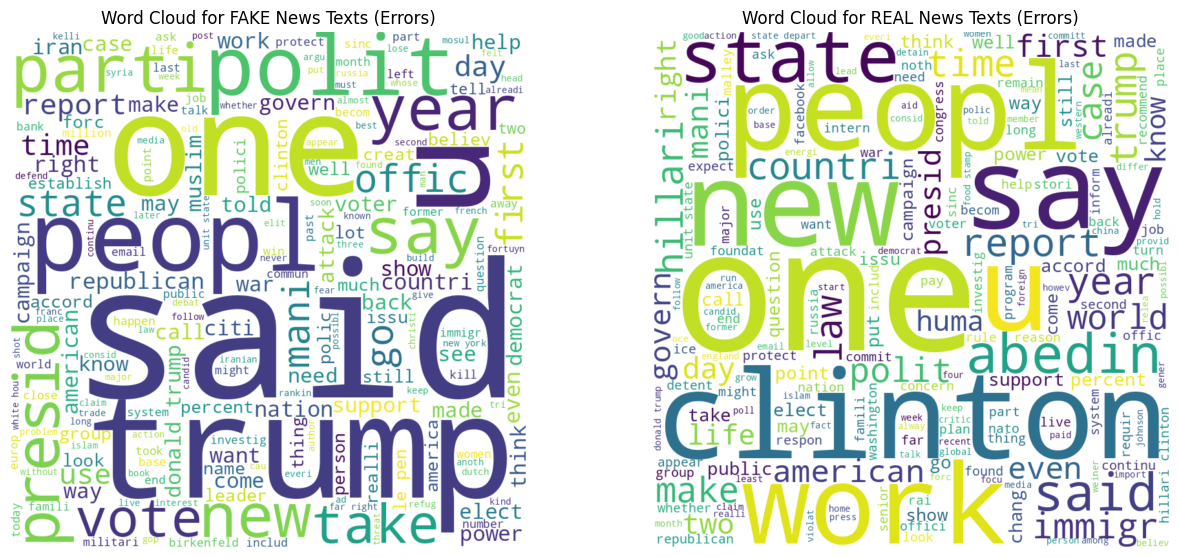

In [23]:
plt.figure(figsize=(13, 11))

for idx, news_type in enumerate(("FAKE", "REAL")):
    texts = " ".join(errors[errors["label"] == news_type]["text_clean"])
    news_wordcloud = WordCloud(
        width=800, height=800, background_color="white"
    ).generate(texts)
    plt.subplot(2, 2, idx + 3)
    plt.imshow(news_wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {news_type} News Texts (Errors)")
    plt.axis("off")

plt.tight_layout()
plt.show()

- The word cloud for both fake and real news errors seems to share some common terms with the overall data clouds. However, some terms might appear more or less prominently compared to the overall dataset.

### Does the text sentiment characteristics of the articles are maintained w.r.t their coresponding news types?
For the last, let's plot the sentiment counts in errors.

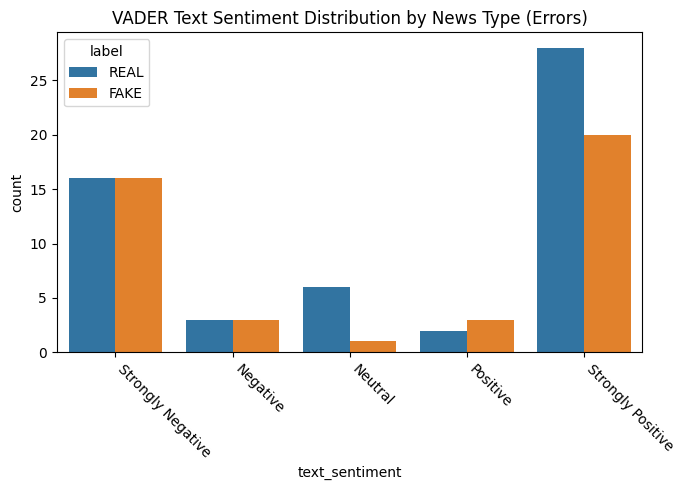

In [24]:
order = ["Strongly Negative", "Negative", "Neutral", "Positive", "Strongly Positive"]

plt.figure(figsize=(7, 5))
ax = sns.countplot(x="text_sentiment", order=order, data=errors, hue="label")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
plt.title("VADER Text Sentiment Distribution by News Type (Errors)")

plt.tight_layout()
plt.show();

- There's a significant number of errors in the "Strongly Positive" sentiment class, specially for real news. This suggests that the model struggles with correctly classifying real news articles that contain strongly negative sentiment
- The counts of errors across sentiment classes are relatively small compared to the overall distribution, which indicates that the model performs well in general. However, the errors that occur are disproportionately in the extreme sentiment classes.

# Conclusion
In this project we addressed the problem of detection of fake news.
- We first give a brief review of most common text data concepts and processing techniques.
- Then we proceed to analyze the text data main features, like text size, common words and sentiment polarity. We also applied some text processing techniques to extract some of the features.
- We applied the TF-IDF vector extraction techinique to create the feature matrix and trained a list of machine learning models using it to detect fake news.
- Wel also analyzed the prediction errors of the final model, comparing with the analysis of the whole data.